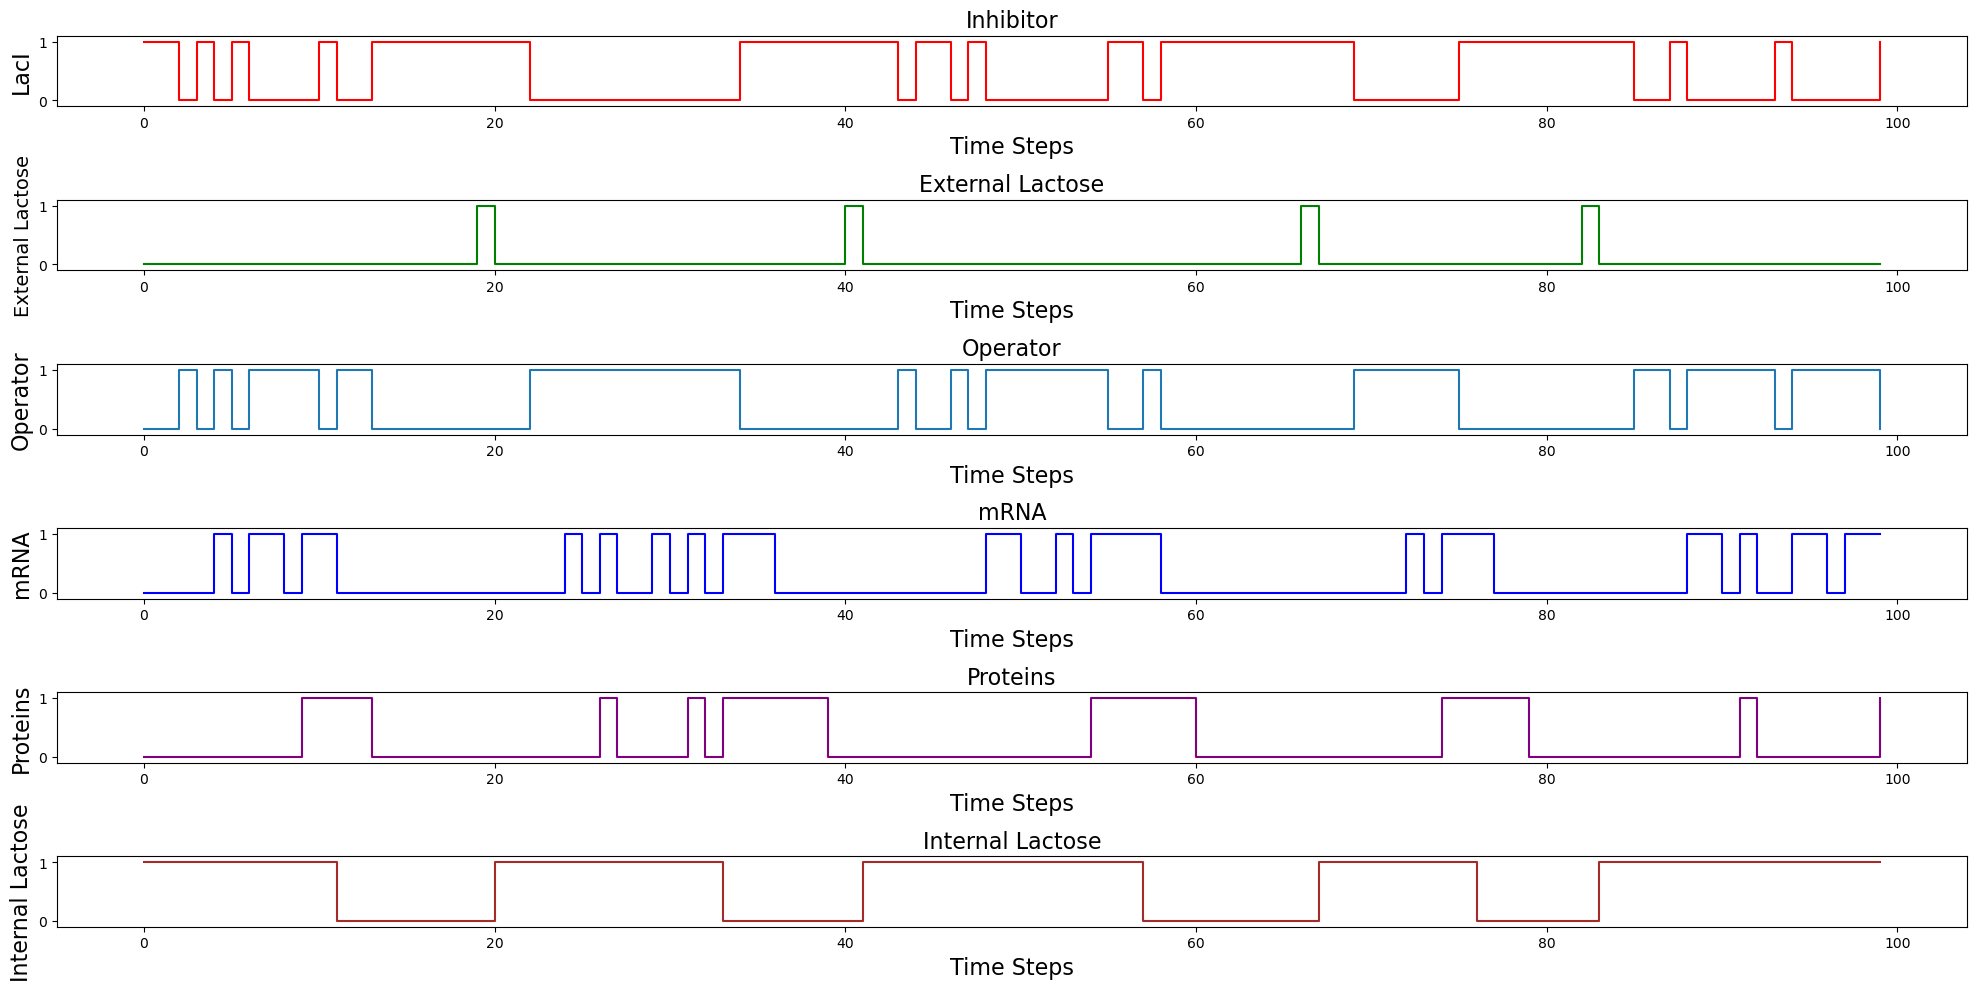

In [48]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0

# Initialize states
states = {
    'O': 0,  # Operon initially bound
    'I': 1,  # lacI initially bound to operon
    'L': 1,  # Some external lactose there
    'Li': 0,  # No internal lactose initially
    'M': 0,  # No mRNA initially
    'P': 0   # No proteins initially
}

# Parameters (probabilities of events occurring)
params = {
    'lacI_binding': 0.8,   # Probability LacI binds to Operon if free
    'lactose_binding': 0.8, # Probability lactose binds to LacI
    'lactose_internalization': 0.8,  # degradation of lactose by protein
   
    'mRNA_production_withoutinitialoperator': 0.8, # production of mRNA by operon if it has just become free
    'mRNA_production_withinitialoperator': 0.9, # production of mRNA by operon if it has been free for some time
    'mRNA_degradation_withoperator': 0.9, # mRNA stability if operon is free
    'mRNA_degradation_withoutoperator': 0.1, #mRNA stability is operon is off
    'protein_production_withoutinitialprotein': 0.8,  # production of protein by mRNA if it has just been transcribed 
    'protein_production_withinitialprotein': 0.9,  # production of protein by operon if it has been transcribed for some time
    'protein_degradation_withmRNA': 0.1, # protein stability if mRNA is being produced
    'protein_degradation_withoutmRNA': 0.1,  # protein stability is mRNA is not being produced
    'entry of lactose': 0.2 #entering of external lactose into the cell 

}

steps = 100
history = np.zeros((steps, 6))

for t in range(steps):
   
    # if we have external lactose
    if states['L'] == 1:
        # internal lactose is on
        states['Li']=1
        # external lactose is off 
        states['L']=0

    # if lactose is on
    if states['Li'] == 1 and t>1:
        # if lactose has been on for the last 2 epochs
        if history[t-2][3]==1:
            # update the status of Inhibitor based on probability of binding of lactose to inhibitor
            states['I'] = update_state(states['I'], 1-params['lactose_binding'])
    # if lactose is off  
    else:
        #if inhibitor is off
        if states['I']==0:
            # update inhibitor status based on ability of inhibitor to operon
            states['I'] = update_state(states['I'], params['lacI_binding'])
    
    # if inhibitor is off, operator is on and vice versa
    states['O'] = 1 if states['I'] == 0 else 0
    
 
    # if operon is on  
    if states['O']==1 and t>2:
        # if operon has been on for the last 2 epochs and mRNA is off
        if history[t-2][0]==1 and states['M']==0:
            # update mRNA 
            states['M'] = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
        # if operon has been on for the last 2 epochs and mRNA is on
        elif history[t-2][0]==1 and states['M']==1:
            # update mRNA, with a probability of degradation
            states['M'] = update_state(states['M'], params['mRNA_production_withinitialoperator'])
            states['M']=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
        # enough epochs has not passed for operon state change to have an impact 
        elif history[t-2][0]==0:
            states['M']=states['M']
    # if operon is off    
    elif states['O']==0:
        # if operon has been of for more than 2 epochs, and mRNA is still on
        if history[t-2][0]==0 and states['M']==1:
            # update status of mRNA, with high degradation
            states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
    elif t<=2:
        states['M']=0
        
    # if mRNA is on
    if states['M']==1 and t>2:
        # if mRNA has been on for the last 2 epochs and protein is off
        if history[t-2][4]==1 and states['P']==0:
            # update protein
            states['P'] = update_state(states['P'], params['protein_production_withoutinitialprotein'])
         # if mRNA has been on for the last 2 epochs and protein is on
        elif history[t-2][4]==1 and states['P']==1:
            # update protein, with a probability of degradation
            states['P'] = update_state(states['P'], params['protein_production_withinitialprotein'])
            states['P']=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
        # enough epochs has not passed for mRNA state change to have an impact 
        elif history[t-2][4]==0:
            states['P']=states['P']
    # if mRNA is off      
    elif states['M']==0:
        # if mRNA has been of for more than 2 epochs, and protein is still on
        if history[t-2][4]==0 and states['P']==1:
            # update status of protein, with high degradation
            states['P']=update_state(states['P'],params['protein_degradation_withoutmRNA'])
    elif t<=2:
        states['P']=0
        
    
    # if protein is on
    if states['P']==1 and t>2:
        # if protein has been of for more than 2 epochs, and lactose is still on
        if history[t-2][5]==1 and states['Li']==1:
            # switch off lactose
            states['Li']=update_state(states['Li'], 1-params['lactose_internalization'])
        else:
            if states['Li']==0:
                states['Li']=0
    elif t<=2:
        states['Li']=1
        
        

    history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
    # if lactose is off
    if states['Li'] == 0:
        # if lactose has been off for the last 3 epochs
        if history[t-2][3]==0 and history[t-3][3]==0:
            # try to bring in external lactose
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        

import matplotlib.pyplot as plt
labels = ['Operator', 'LacI', 'Lactose', 'Internal Lactose', 'mRNA', 'Protein']

steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.title('Inhibitor',fontsize=16)
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose',fontsize=14)
plt.title('External Lactose',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator',fontsize=16)
plt.title('Operator',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA',fontsize=16)
plt.title('mRNA',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins',fontsize=16)
plt.title('Proteins',fontsize=16)
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps',fontsize=16)

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose',fontsize=16)
plt.title('Internal Lactose',fontsize=16)
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps',fontsize=16)
plt.savefig("Demo_non_markovian.png")
plt.tight_layout()
plt.show()


# If lactose unable to bind to inhibitor - 
# Observation - if lactose is unable to bind to inhibitor, then repressor is forever bound to operon, no MRNA, protein, and no change in internal lactose level

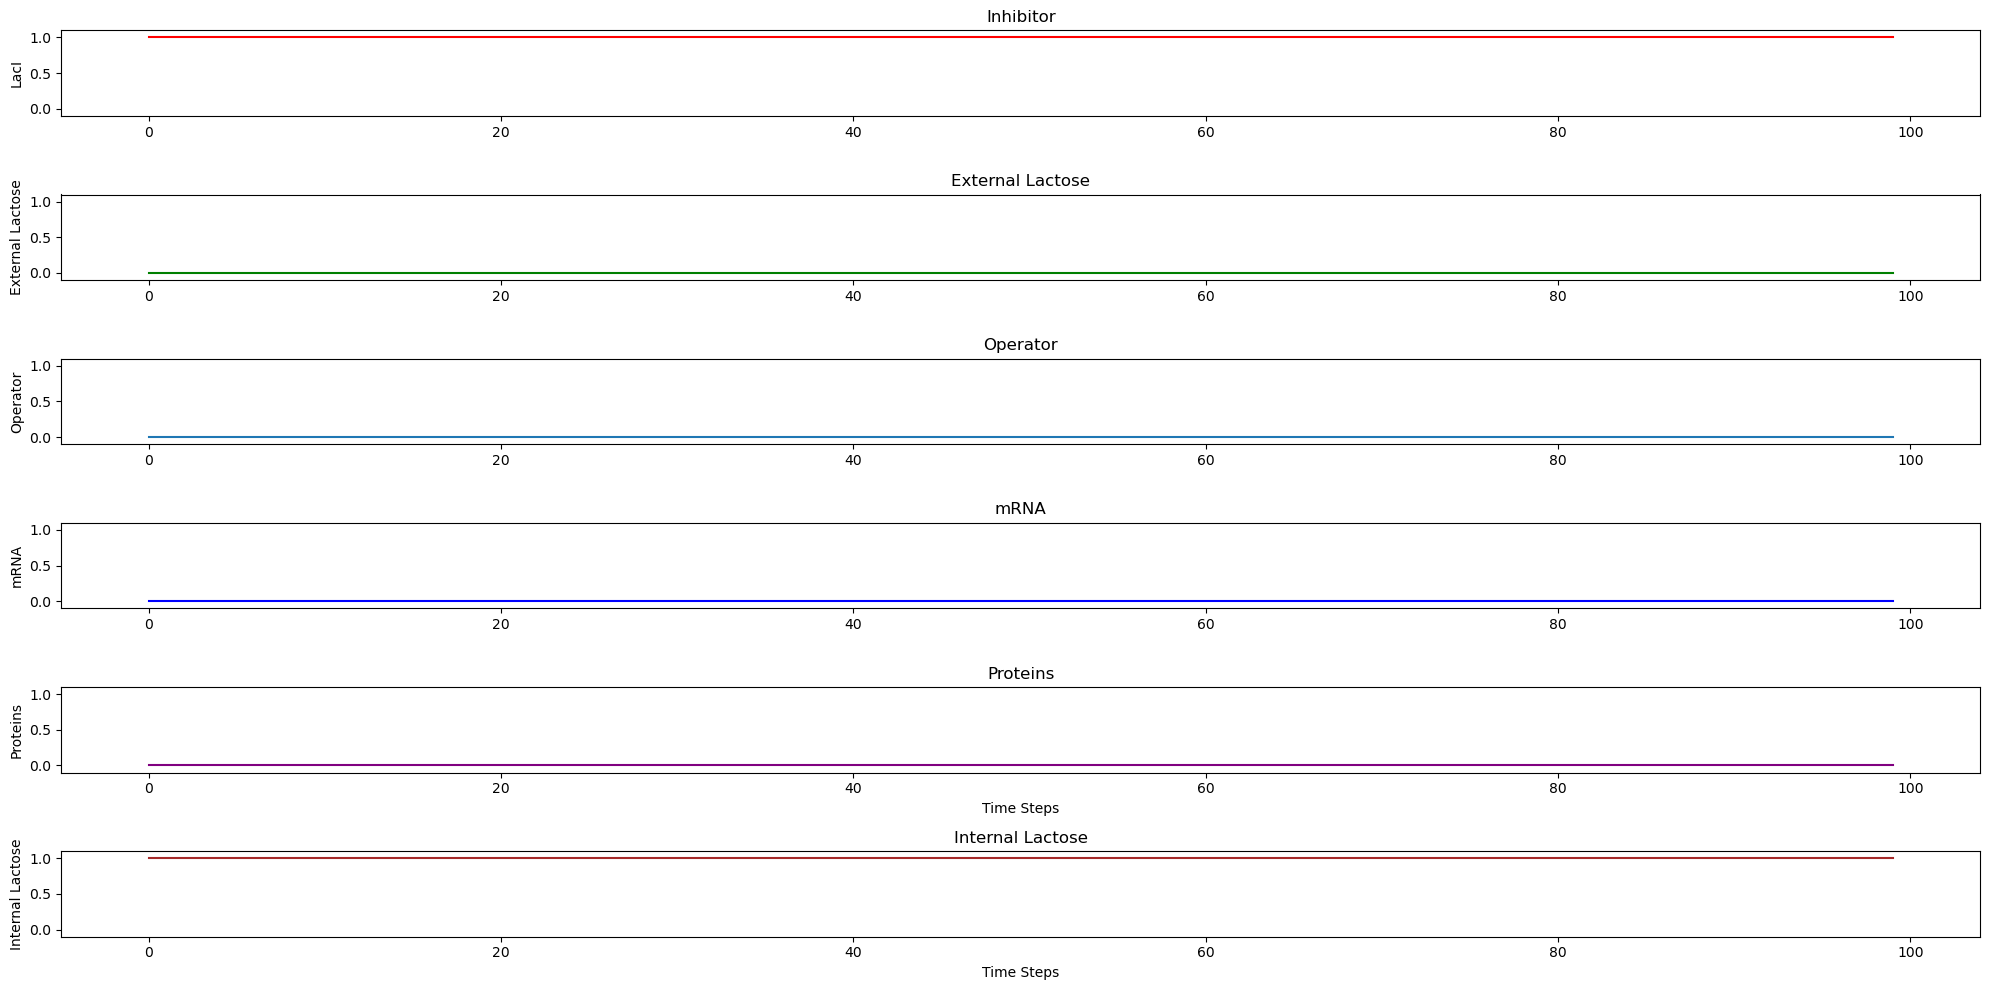

In [27]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0


states = {
    'O': 0,  
    'I': 1,  
    'L': 1,  
    'Li': 0, 
    'M': 0,  
    'P': 0   
}


params = {
    'lacI_binding': 0.8,   
    
    'lactose_binding': 0.001, # Lactose binding strength is now very low
    'lactose_internalization': 0.8,
   
    'mRNA_production_withoutinitialoperator': 0.8, 
    'mRNA_production_withinitialoperator': 0.9,
    'mRNA_degradation_withoperator': 0.1, 
    'mRNA_degradation_withoutoperator': 0.1, 
    'protein_production_withoutinitialprotein': 0.8, 
    'protein_production_withinitialprotein': 0.9,
    'protein_degradation_withmRNA': 0.1, 
    'protein_degradation_withoutmRNA': 0.1, 
    'entry of lactose': 0.9

}

steps = 100
history = np.zeros((steps, 6))

for t in range(steps):
   
    
    if states['L'] == 1:
        
        states['Li']=1
        states['L']=0

    
    if states['Li'] == 1 and t>1:
        if history[t-2][3]==1:
            states['I'] = update_state(states['I'], 1-params['lactose_binding'])
        #else:
            #states['I']= update_state(states['I'], params['lacI_binding'])
    else:
        if states['I']==0:
            
            states['I'] = update_state(states['I'], params['lacI_binding'])
    
  
    states['O'] = 1 if states['I'] == 0 else 0
    
 
        
    if states['O']==1 and t>2:
        if history[t-2][0]==1 and states['M']==0:
            states['M'] = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
        elif history[t-2][0]==1 and states['M']==1:
            states['M'] = update_state(states['M'], params['mRNA_production_withinitialoperator'])
            states['M']=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
        elif history[t-2][0]==0:
            states['M']=states['M']
          
    elif states['O']==0:
        if history[t-2][0]==0 and states['M']==1:
            states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
    elif t<=2:
        states['M']=0
        
    # What happens if m becomes 0/
    if states['M']==1 and t>2:
        if history[t-2][4]==1 and states['P']==0:
            states['P'] = update_state(states['P'], params['protein_production_withoutinitialprotein'])
        elif history[t-2][4]==1 and states['P']==1:
            states['P'] = update_state(states['P'], params['protein_production_withinitialprotein'])
            states['P']=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
        elif history[t-2][4]==0:
            states['P']=states['P']
          
    elif states['M']==0:
        if history[t-2][4]==0 and states['P']==1:
            states['P']=update_state(states['P'],params['protein_degradation_withoutmRNA'])
    elif t<=2:
        states['P']=0
        
    
    #
    if states['P']==1 and t>2:
        if history[t-2][5]==1 and states['Li']==1:
            states['Li']=update_state(states['Li'], 1-params['lactose_internalization'])
        else:
            if states['Li']==0:
                states['Li']=0
    elif t<=2:
        states['Li']=1
        
        

    history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
    if states['Li'] == 0:
        if history[t-2][3]==0 and history[t-3][3]==0:
        
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        

import matplotlib.pyplot as plt
labels = ['Operator', 'LacI', 'Lactose', 'Internal Lactose', 'mRNA', 'Protein']

steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI')

plt.title('Inhibitor')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose')
plt.title('External Lactose')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator')
plt.title('Operator')
plt.ylim(-0.1, 1.1)
plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA')
plt.title('mRNA')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins')
plt.title('Proteins')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose')
plt.title('Internal Lactose')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.tight_layout()
plt.show()


# If inhibitor fails to bind with operator
# Then, operon is constitutively active, MRNA, protein is continously found

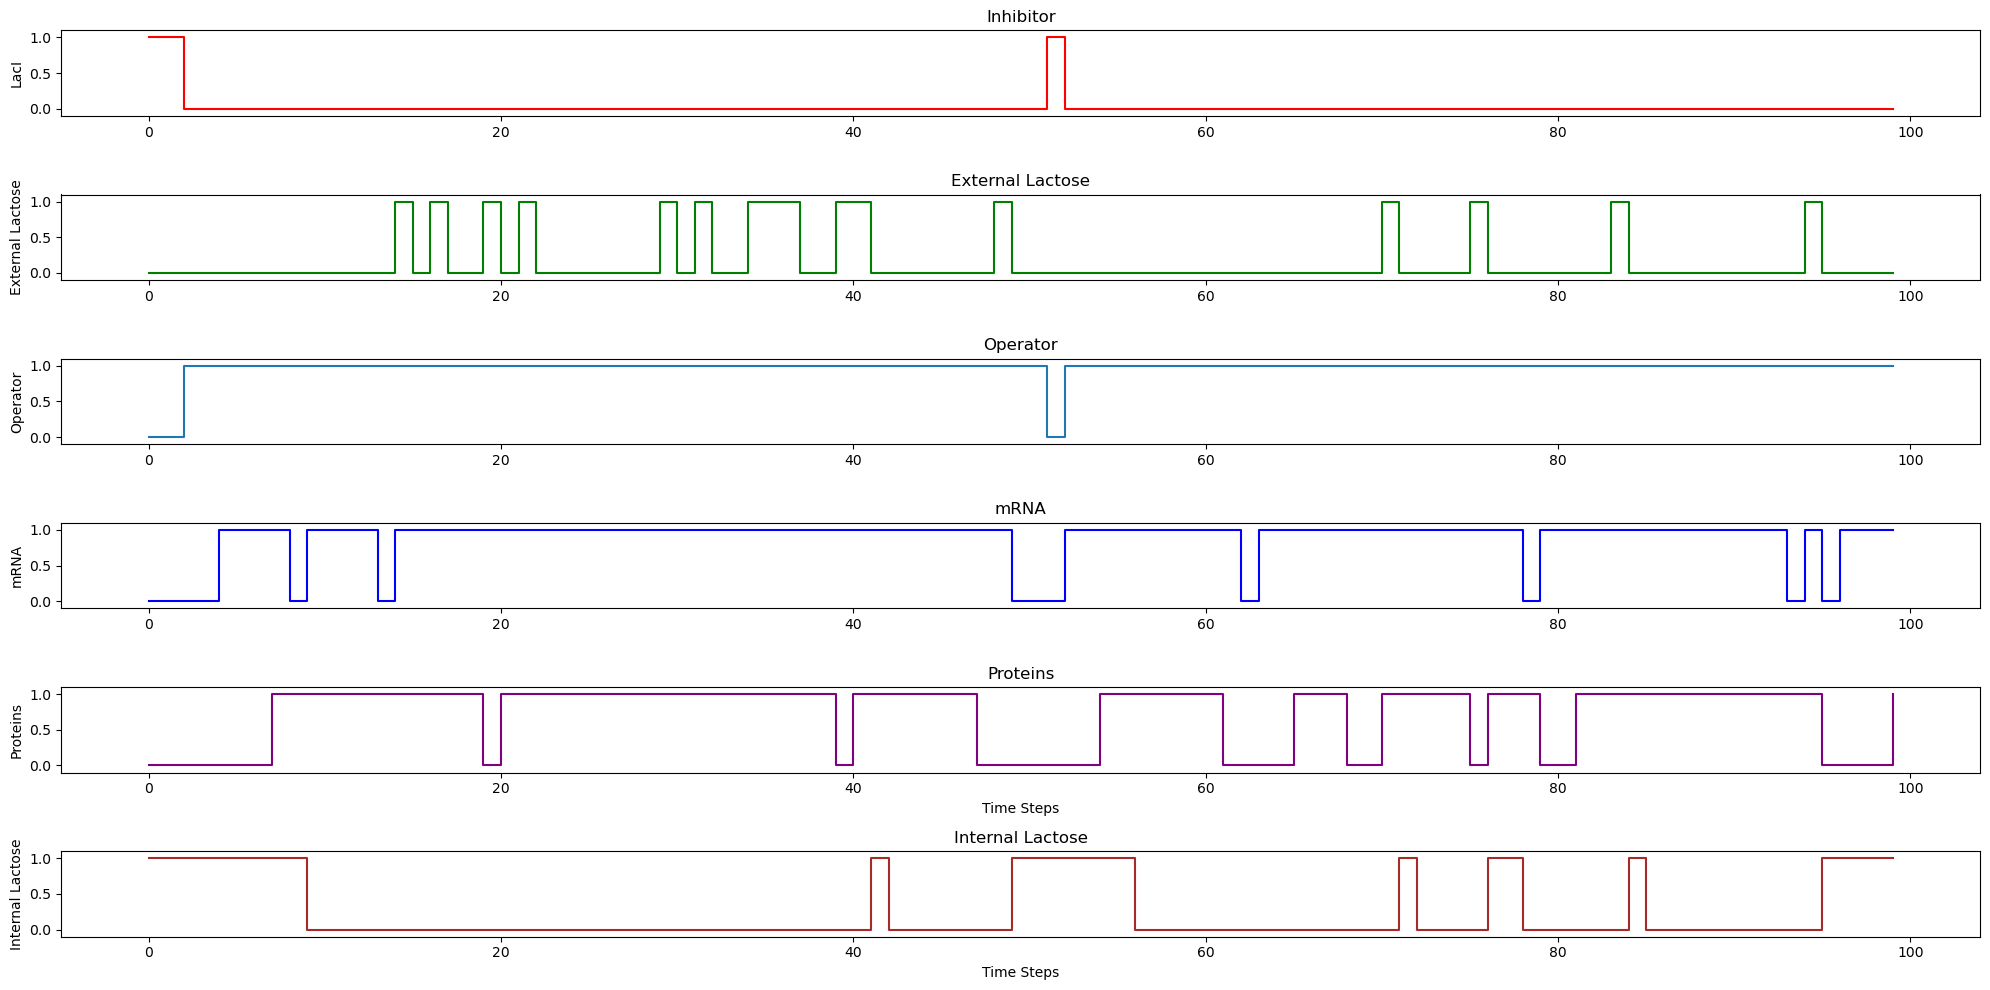

In [33]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0


states = {
    'O': 0, 
    'I': 1,  
    'L': 1,  
    'Li': 0,  
    'M': 0,  
    'P': 0   
}


params = {
    'lacI_binding': 0.0001,# Poor binding strength of lacI to Operon   

    'lactose_binding': 0.9, 
    'lactose_internalization': 0.8, 
   
    'mRNA_production_withoutinitialoperator': 0.8, 
    'mRNA_production_withinitialoperator': 0.9,
    'mRNA_degradation_withoperator': 0.1, 
    'mRNA_degradation_withoutoperator': 0.1,
    'protein_production_withoutinitialprotein': 0.8, 
    'protein_production_withinitialprotein': 0.9,
    'protein_degradation_withmRNA': 0.1, 
    'protein_degradation_withoutmRNA': 0.1, 
    'entry of lactose': 0.2

}

steps = 100
history = np.zeros((steps, 6))

for t in range(steps):
   
    
    if states['L'] == 1:
        
        states['Li']=1
        states['L']=0

    
    if states['Li'] == 1 and t>1:
        if history[t-2][3]==1:
            states['I'] = update_state(states['I'], 1-params['lactose_binding'])
        #else:
            #states['I']= update_state(states['I'], params['lacI_binding'])
    else:
        if states['I']==0:
            
            states['I'] = update_state(states['I'], params['lacI_binding'])
    
  
    states['O'] = 1 if states['I'] == 0 else 0
    
 
        
    if states['O']==1 and t>2:
        if history[t-2][0]==1 and states['M']==0:
            states['M'] = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
        elif history[t-2][0]==1 and states['M']==1:
            states['M'] = update_state(states['M'], params['mRNA_production_withinitialoperator'])
            states['M']=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
        elif history[t-2][0]==0:
            states['M']=states['M']
          
    elif states['O']==0:
        if history[t-2][0]==0 and states['M']==1:
            states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
    elif t<=2:
        states['M']=0
        
    # What happens if m becomes 0/
    if states['M']==1 and t>2:
        if history[t-2][4]==1 and states['P']==0:
            states['P'] = update_state(states['P'], params['protein_production_withoutinitialprotein'])
        elif history[t-2][4]==1 and states['P']==1:
            states['P'] = update_state(states['P'], params['protein_production_withinitialprotein'])
            states['P']=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
        elif history[t-2][4]==0:
            states['P']=states['P']
          
    elif states['M']==0:
        if history[t-2][4]==0 and states['P']==1:
            states['P']=update_state(states['P'],params['protein_degradation_withoutmRNA'])
    elif t<=2:
        states['P']=0
        
    
    #
    if states['P']==1 and t>2:
        if history[t-2][5]==1 and states['Li']==1:
            states['Li']=update_state(states['Li'], 1-params['lactose_internalization'])
        else:
            if states['Li']==0:
                states['Li']=0
    elif t<=2:
        states['Li']=1
        
        

    history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
    if states['Li'] == 0:
        if history[t-2][3]==0 and history[t-3][3]==0:
        
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        

import matplotlib.pyplot as plt
labels = ['Operator', 'LacI', 'Lactose', 'Internal Lactose', 'mRNA', 'Protein']

steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI')

plt.title('Inhibitor')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose')
plt.title('External Lactose')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator')
plt.title('Operator')
plt.ylim(-0.1, 1.1)
plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA')
plt.title('mRNA')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins')
plt.title('Proteins')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose')
plt.title('Internal Lactose')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.tight_layout()
plt.show()


# if problem in transcription

# Operon is free, no MRNA is formed, hence no protein is formed, hence lactose cant be removed; hence lactose is always bound to repressor; hence operon is always free

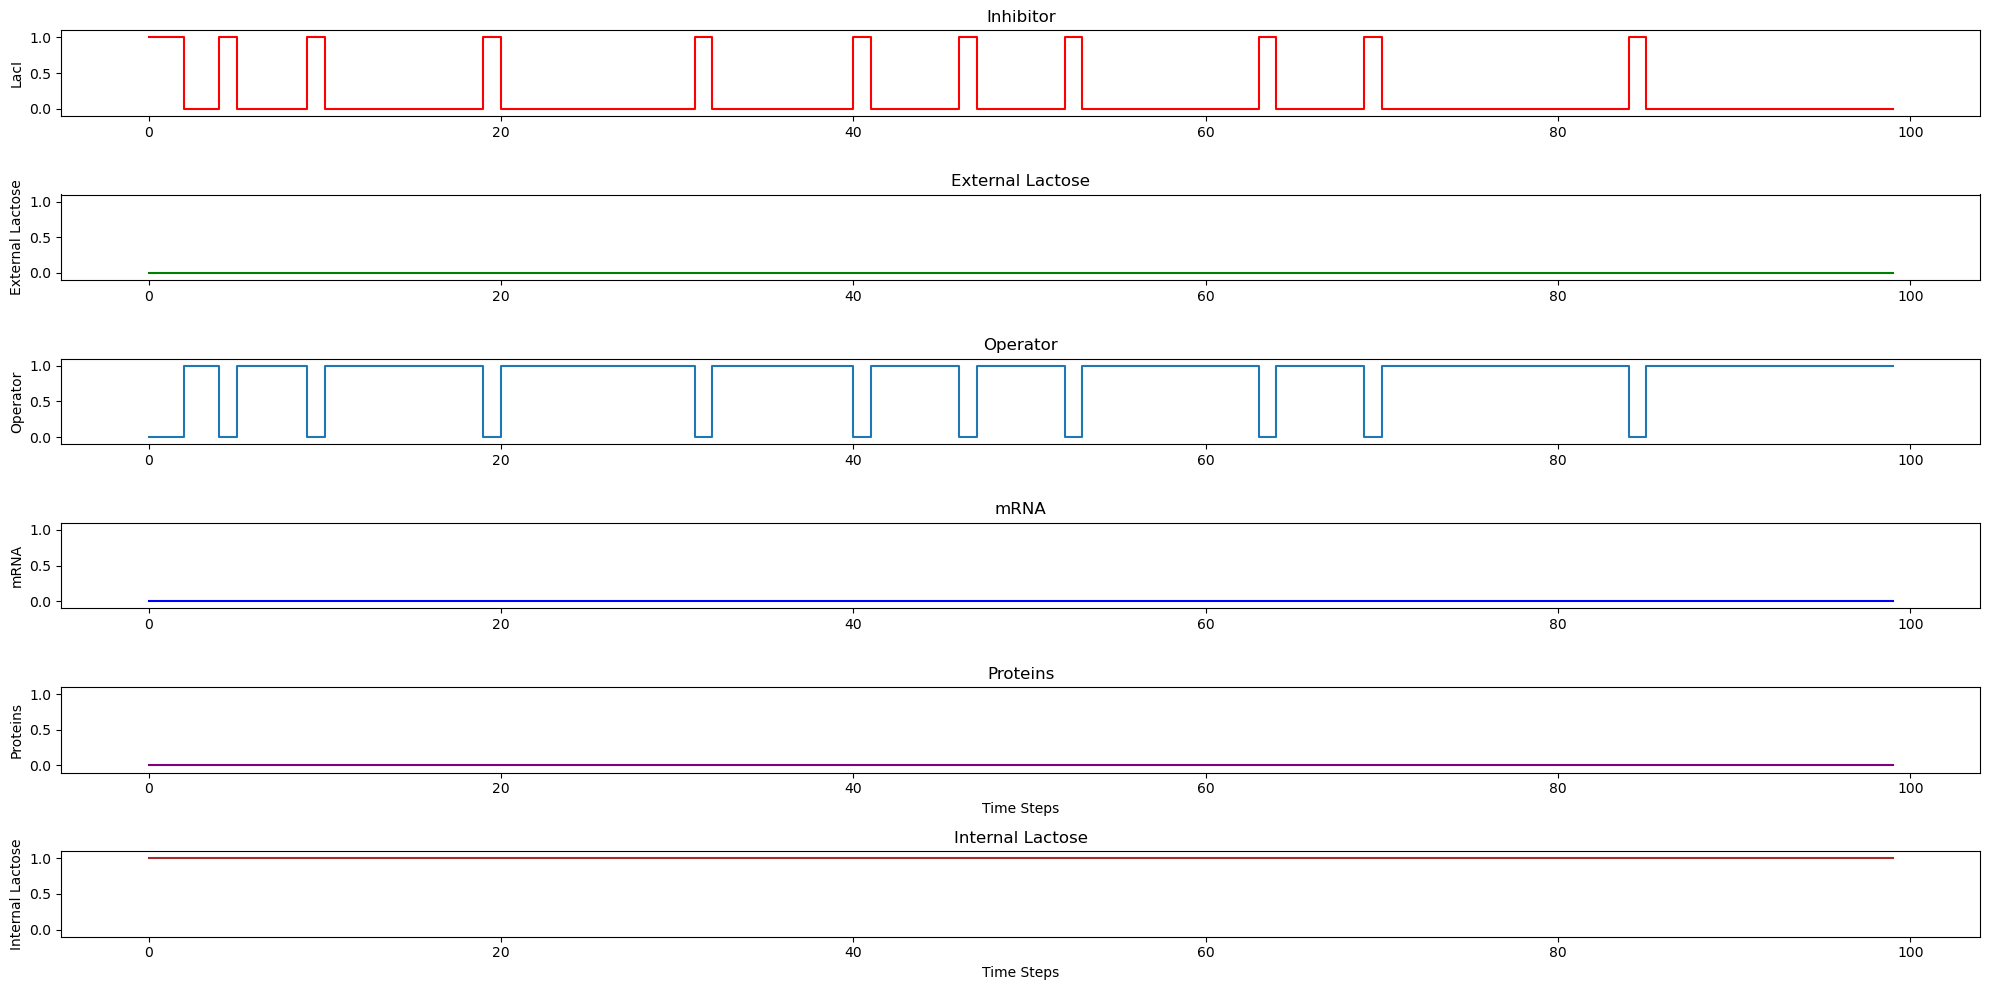

In [41]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0


states = {
    'O': 0,  
    'I': 1,  
    'L': 1, 
    'Li': 0,  
    'M': 0,  
    'P': 0  
}


params = {
    'lacI_binding': 0.9,   
  
    'lactose_binding': 0.9, 
    'lactose_internalization': 0.8, 
   
    'mRNA_production_withoutinitialoperator': 0.01, # cant produce mRNA
    'mRNA_production_withinitialoperator': 0.01, # cant produce mRNA
    'mRNA_degradation_withoperator': 0.1, 
    'mRNA_degradation_withoutoperator': 0.1, 
    'protein_production_withoutinitialprotein': 0.8, 
    'protein_production_withinitialprotein': 0.9,
    'protein_degradation_withmRNA': 0.1, 
    'protein_degradation_withoutmRNA': 0.1, 
    'entry of lactose': 0.9

}

steps = 100
history = np.zeros((steps, 6))

for t in range(steps):
   
    
    if states['L'] == 1:
        
        states['Li']=1
        states['L']=0

    
    if states['Li'] == 1 and t>1:
        if history[t-2][3]==1:
            states['I'] = update_state(states['I'], 1-params['lactose_binding'])
        #else:
            #states['I']= update_state(states['I'], params['lacI_binding'])
    else:
        if states['I']==0:
            
            states['I'] = update_state(states['I'], params['lacI_binding'])
    
  
    states['O'] = 1 if states['I'] == 0 else 0
    
 
        
    if states['O']==1 and t>2:
        if history[t-2][0]==1 and states['M']==0:
            states['M'] = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
        elif history[t-2][0]==1 and states['M']==1:
            states['M'] = update_state(states['M'], params['mRNA_production_withinitialoperator'])
            states['M']=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
        elif history[t-2][0]==0:
            states['M']=states['M']
          
    elif states['O']==0:
        if history[t-2][0]==0 and states['M']==1:
            states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
    elif t<=2:
        states['M']=0
        
    # What happens if m becomes 0/
    if states['M']==1 and t>2:
        if history[t-2][4]==1 and states['P']==0:
            states['P'] = update_state(states['P'], params['protein_production_withoutinitialprotein'])
        elif history[t-2][4]==1 and states['P']==1:
            states['P'] = update_state(states['P'], params['protein_production_withinitialprotein'])
            states['P']=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
        elif history[t-2][4]==0:
            states['P']=states['P']
          
    elif states['M']==0:
        if history[t-2][4]==0 and states['P']==1:
            states['P']=update_state(states['P'],params['protein_degradation_withoutmRNA'])
    elif t<=2:
        states['P']=0
        
    
    #
    if states['P']==1 and t>2:
        if history[t-2][5]==1 and states['Li']==1:
            states['Li']=update_state(states['Li'], 1-params['lactose_internalization'])
        else:
            if states['Li']==0:
                states['Li']=0
    elif t<=2:
        states['Li']=1
        
        

    history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
    if states['Li'] == 0:
        if history[t-2][3]==0 and history[t-3][3]==0:
        
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        

import matplotlib.pyplot as plt
labels = ['Operator', 'LacI', 'Lactose', 'Internal Lactose', 'mRNA', 'Protein']

steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI')

plt.title('Inhibitor')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose')
plt.title('External Lactose')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator')
plt.title('Operator')
plt.ylim(-0.1, 1.1)
plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA')
plt.title('mRNA')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins')
plt.title('Proteins')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose')
plt.title('Internal Lactose')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.tight_layout()
plt.show()


# Problems in Translation
# Protein is not being formed; hence lactose is not being removed, operon is always free, mRNA is always being produced; repressor is always bound 

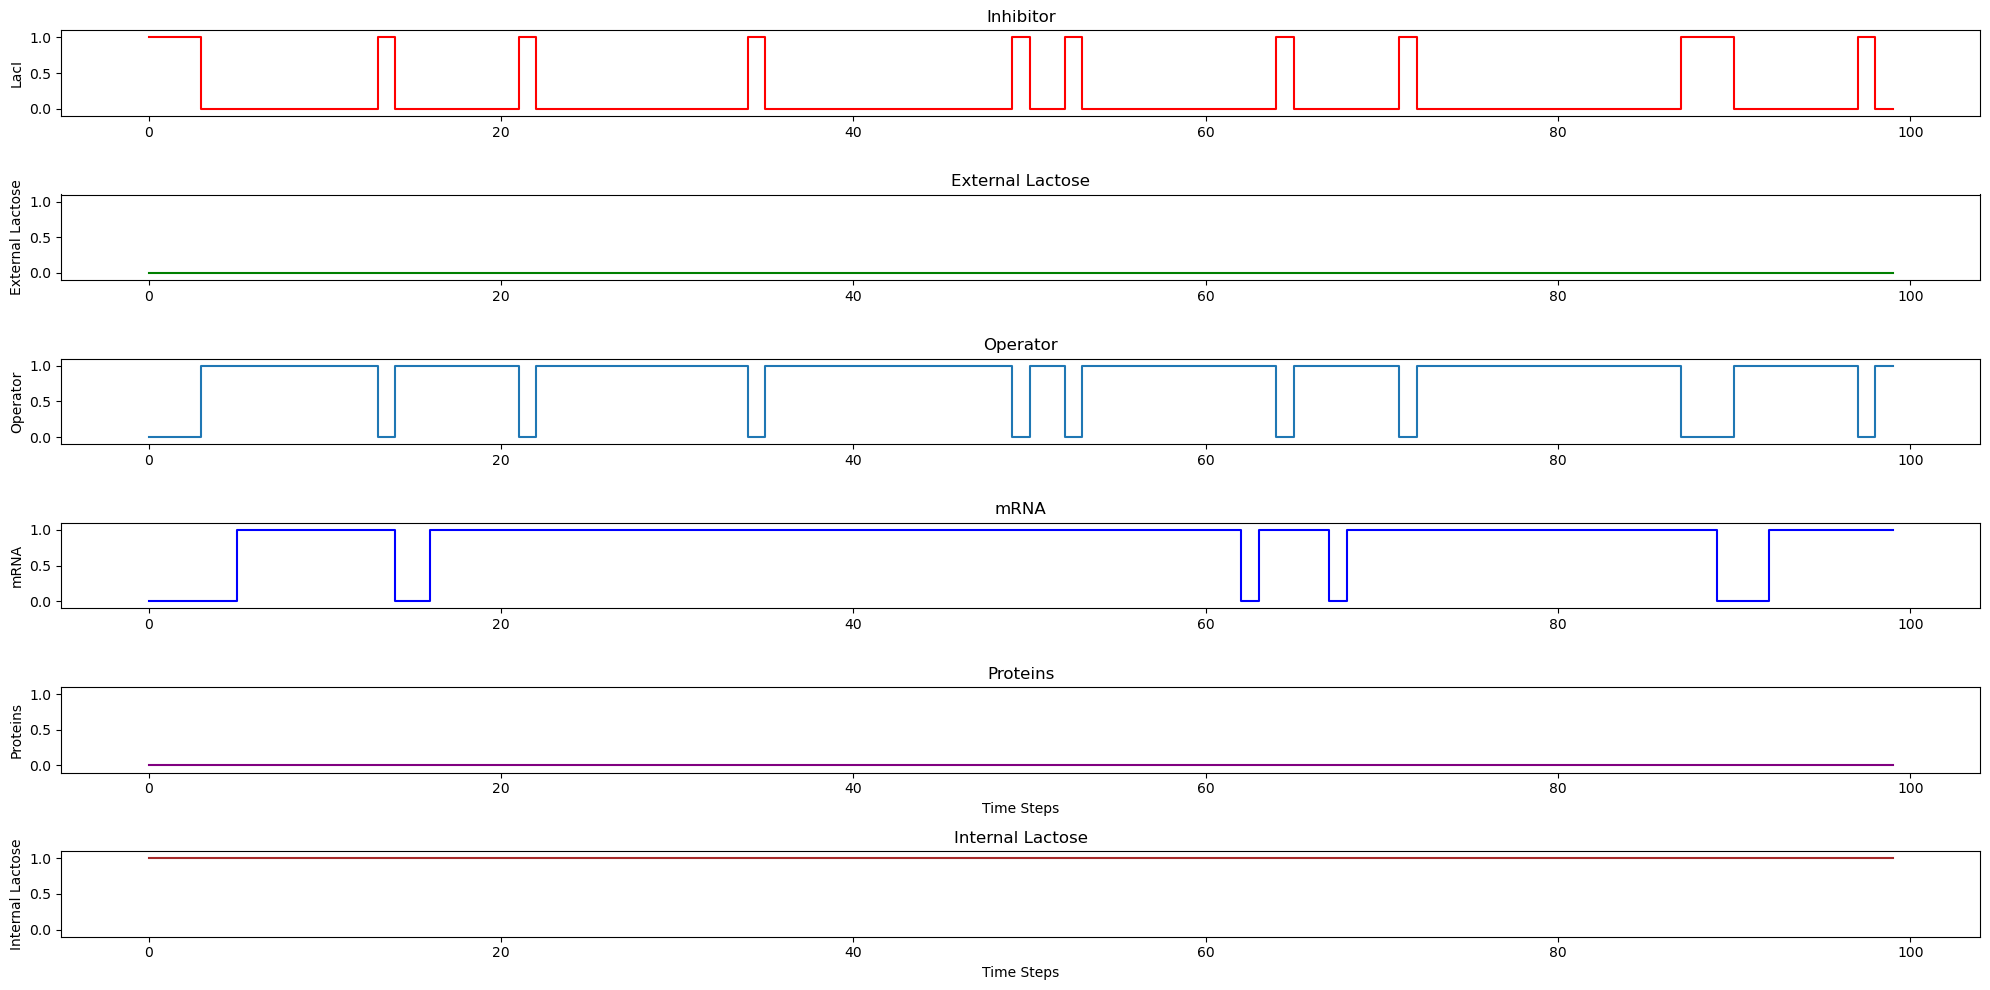

In [43]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0


states = {
    'O': 0, 
    'I': 1, 
    'L': 1,  
    'Li': 0,  
    'M': 0,  
    'P': 0   
}


params = {
    'lacI_binding': 0.9,   

    'lactose_binding': 0.9, 
    'lactose_internalization': 0.8, 
   
    'mRNA_production_withoutinitialoperator': 0.8, 
    'mRNA_production_withinitialoperator': 0.9,
    'mRNA_degradation_withoperator': 0.1, 
    'mRNA_degradation_withoutoperator': 0.1, 
    'protein_production_withoutinitialprotein': 0.001, # cant produce protein 
    'protein_production_withinitialprotein': 0.001,  # cant produce protein
    'protein_degradation_withmRNA': 0.1, 
    'protein_degradation_withoutmRNA': 0.1, 
    'entry of lactose': 0.9

}

steps = 100
history = np.zeros((steps, 6))

for t in range(steps):
   
    
    if states['L'] == 1:
        
        states['Li']=1
        states['L']=0

    
    if states['Li'] == 1 and t>1:
        if history[t-2][3]==1:
            states['I'] = update_state(states['I'], 1-params['lactose_binding'])
        #else:
            #states['I']= update_state(states['I'], params['lacI_binding'])
    else:
        if states['I']==0:
            
            states['I'] = update_state(states['I'], params['lacI_binding'])
    
  
    states['O'] = 1 if states['I'] == 0 else 0
    
 
        
    if states['O']==1 and t>2:
        if history[t-2][0]==1 and states['M']==0:
            states['M'] = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
        elif history[t-2][0]==1 and states['M']==1:
            states['M'] = update_state(states['M'], params['mRNA_production_withinitialoperator'])
            states['M']=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
        elif history[t-2][0]==0:
            states['M']=states['M']
          
    elif states['O']==0:
        if history[t-2][0]==0 and states['M']==1:
            states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
    elif t<=2:
        states['M']=0
        
    # What happens if m becomes 0/
    if states['M']==1 and t>2:
        if history[t-2][4]==1 and states['P']==0:
            states['P'] = update_state(states['P'], params['protein_production_withoutinitialprotein'])
        elif history[t-2][4]==1 and states['P']==1:
            states['P'] = update_state(states['P'], params['protein_production_withinitialprotein'])
            states['P']=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
        elif history[t-2][4]==0:
            states['P']=states['P']
          
    elif states['M']==0:
        if history[t-2][4]==0 and states['P']==1:
            states['P']=update_state(states['P'],params['protein_degradation_withoutmRNA'])
    elif t<=2:
        states['P']=0
        
    
    #
    if states['P']==1 and t>2:
        if history[t-2][5]==1 and states['Li']==1:
            states['Li']=update_state(states['Li'],1-params['lactose_internalization'])
        else:
            if states['Li']==0:
                states['Li']=0
    elif t<=2:
        states['Li']=1
        
        

    history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
    if states['Li'] == 0:
        if history[t-2][3]==0 and history[t-3][3]==0:
        
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        

import matplotlib.pyplot as plt
labels = ['Operator', 'LacI', 'Lactose', 'Internal Lactose', 'mRNA', 'Protein']

steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI')

plt.title('Inhibitor')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose')
plt.title('External Lactose')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator')
plt.title('Operator')
plt.ylim(-0.1, 1.1)
plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA')
plt.title('mRNA')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins')
plt.title('Proteins')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose')
plt.title('Internal Lactose')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.tight_layout()
plt.show()


# Problems in Protein Degradation of Lactose
# Even if protein is formed; it is unable to degrade lactose; hence lactose is not being removed, operon is always free, mRNA is always being produced; repressor is always bound, protein is always being produced

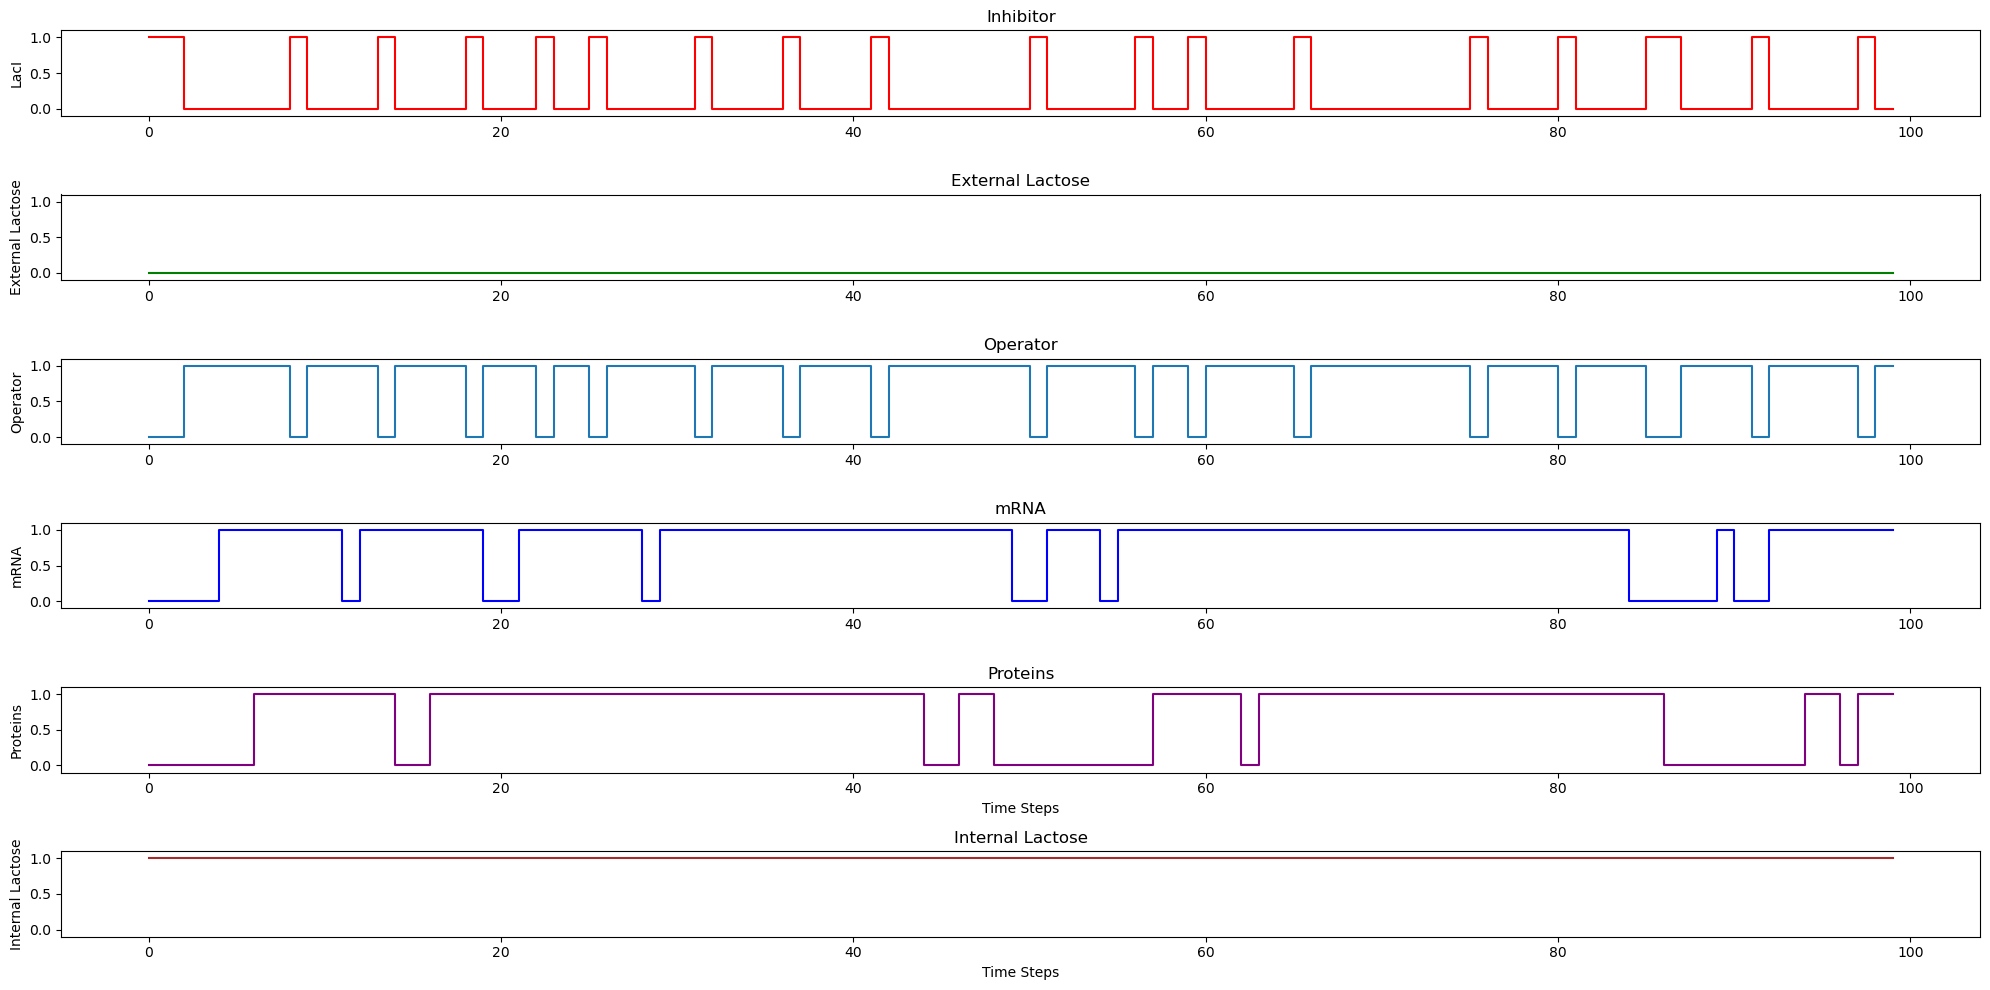

In [40]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0


states = {
    'O': 0, 
    'I': 1,  
    'L': 1,  
    'Li': 0,  
    'M': 0,  
    'P': 0   
}


params = {
    'lacI_binding': 0.8,   

    'lactose_binding': 0.8, 
    'lactose_internalization': 0.0001, # cant degrade lactose
   
    'mRNA_production_withoutinitialoperator': 0.8, 
    'mRNA_production_withinitialoperator': 0.9,
    'mRNA_degradation_withoperator': 0.1, 
    'mRNA_degradation_withoutoperator': 0.1, 
    'protein_production_withoutinitialprotein': 0.8, 
    'protein_production_withinitialprotein': 0.9,
    'protein_degradation_withmRNA': 0.1, 
    'protein_degradation_withoutmRNA': 0.1, 
    'entry of lactose': 0.9

}

steps = 100
history = np.zeros((steps, 6))

for t in range(steps):
   
    
    if states['L'] == 1:
        
        states['Li']=1
        states['L']=0

    
    if states['Li'] == 1 and t>1:
        if history[t-2][3]==1:
            states['I'] = update_state(states['I'], 1-params['lactose_binding'])
        #else:
            #states['I']= update_state(states['I'], params['lacI_binding'])
    else:
        if states['I']==0:
            
            states['I'] = update_state(states['I'], params['lacI_binding'])
    
  
    states['O'] = 1 if states['I'] == 0 else 0
    
 
        
    if states['O']==1 and t>2:
        if history[t-2][0]==1 and states['M']==0:
            states['M'] = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
        elif history[t-2][0]==1 and states['M']==1:
            states['M'] = update_state(states['M'], params['mRNA_production_withinitialoperator'])
            states['M']=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
        elif history[t-2][0]==0:
            states['M']=states['M']
          
    elif states['O']==0:
        if history[t-2][0]==0 and states['M']==1:
            states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
    elif t<=2:
        states['M']=0
        
    # What happens if m becomes 0/
    if states['M']==1 and t>2:
        if history[t-2][4]==1 and states['P']==0:
            states['P'] = update_state(states['P'], params['protein_production_withoutinitialprotein'])
        elif history[t-2][4]==1 and states['P']==1:
            states['P'] = update_state(states['P'], params['protein_production_withinitialprotein'])
            states['P']=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
        elif history[t-2][4]==0:
            states['P']=states['P']
          
    elif states['M']==0:
        if history[t-2][4]==0 and states['P']==1:
            states['P']=update_state(states['P'],params['protein_degradation_withoutmRNA'])
    elif t<=2:
        states['P']=0
        
    
    #
    if states['P']==1 and t>2:
        if history[t-2][5]==1 and states['Li']==1:
            states['Li']=update_state(states['Li'], 1-params['lactose_internalization'])
        else:
            if states['Li']==0:
                states['Li']=0
    elif t<=2:
        states['Li']=1
        
        

    history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
    if states['Li'] == 0:
        if history[t-2][3]==0 and history[t-3][3]==0:
        
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        

import matplotlib.pyplot as plt
labels = ['Operator', 'LacI', 'Lactose', 'Internal Lactose', 'mRNA', 'Protein']

steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI')

plt.title('Inhibitor')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose')
plt.title('External Lactose')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator')
plt.title('Operator')
plt.ylim(-0.1, 1.1)
plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA')
plt.title('mRNA')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins')
plt.title('Proteins')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose')
plt.title('Internal Lactose')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.tight_layout()
plt.show()


# Problem with lactose transport into the cell

# Hence, after the first time lactose is over, reaction stops, repressor always bound to operon

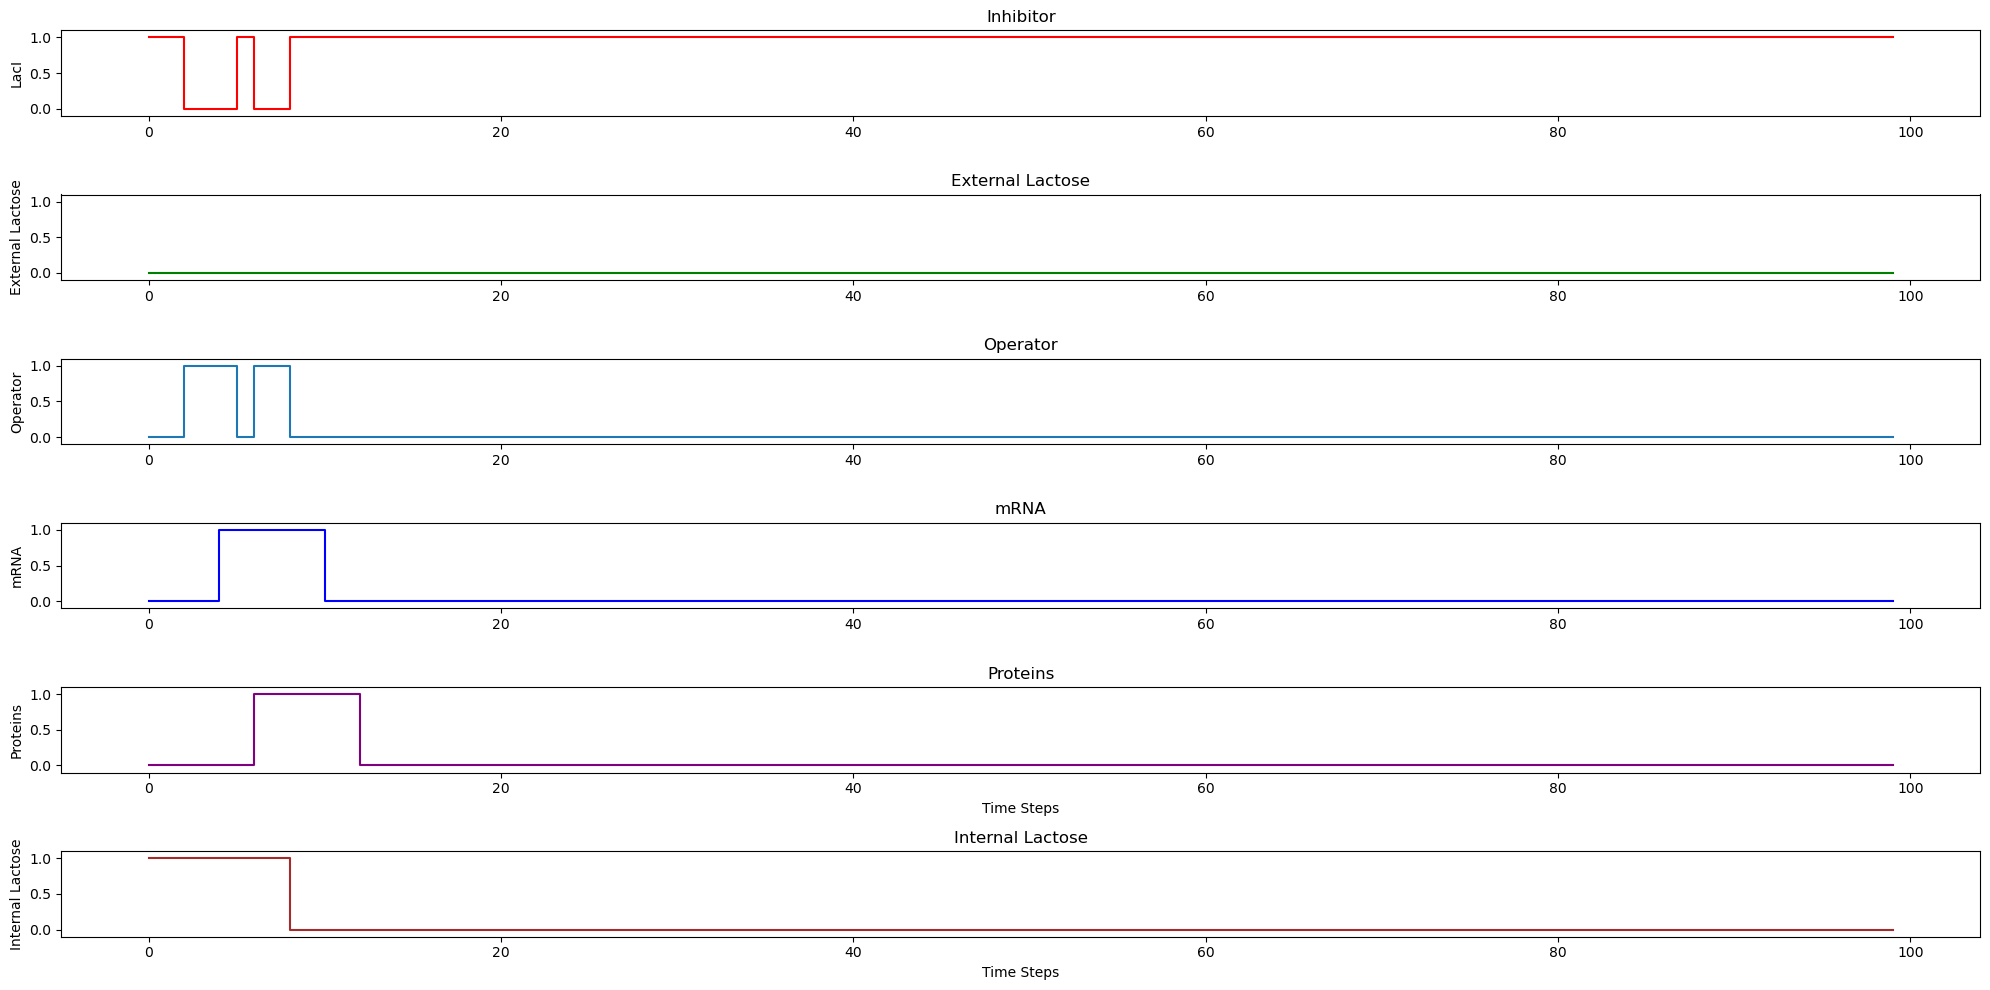

In [39]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0


states = {
    'O': 0,  
    'I': 1, 
    'L': 1, 
    'Li': 0, 
    'M': 0,  
    'P': 0  
}


params = {
    'lacI_binding': 0.8,   
    'lactose_binding': 0.8, 
    'lactose_internalization': 0.8, 
   
    'mRNA_production_withoutinitialoperator': 0.8, 
    'mRNA_production_withinitialoperator': 0.9,
    'mRNA_degradation_withoperator': 0.1, 
    'mRNA_degradation_withoutoperator': 0.1, 
    'protein_production_withoutinitialprotein': 0.8, 
    'protein_production_withinitialprotein': 0.9,
    'protein_degradation_withmRNA': 0.1, 
    'protein_degradation_withoutmRNA': 0.1, 
    'entry of lactose': 0.0001 # cant transport lactose inside

}

steps = 100
history = np.zeros((steps, 6))

for t in range(steps):
   
    
    if states['L'] == 1:
        
        states['Li']=1
        states['L']=0

    
    if states['Li'] == 1 and t>1:
        if history[t-2][3]==1:
            states['I'] = update_state(states['I'], 1-params['lactose_binding'])
        #else:
            #states['I']= update_state(states['I'], params['lacI_binding'])
    else:
        if states['I']==0:
            
            states['I'] = update_state(states['I'], params['lacI_binding'])
    
  
    states['O'] = 1 if states['I'] == 0 else 0
    
 
        
    if states['O']==1 and t>2:
        if history[t-2][0]==1 and states['M']==0:
            states['M'] = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
        elif history[t-2][0]==1 and states['M']==1:
            states['M'] = update_state(states['M'], params['mRNA_production_withinitialoperator'])
            states['M']=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
        elif history[t-2][0]==0:
            states['M']=states['M']
          
    elif states['O']==0:
        if history[t-2][0]==0 and states['M']==1:
            states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
    elif t<=2:
        states['M']=0
        
    # What happens if m becomes 0/
    if states['M']==1 and t>2:
        if history[t-2][4]==1 and states['P']==0:
            states['P'] = update_state(states['P'], params['protein_production_withoutinitialprotein'])
        elif history[t-2][4]==1 and states['P']==1:
            states['P'] = update_state(states['P'], params['protein_production_withinitialprotein'])
            states['P']=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
        elif history[t-2][4]==0:
            states['P']=states['P']
          
    elif states['M']==0:
        if history[t-2][4]==0 and states['P']==1:
            states['P']=update_state(states['P'],params['protein_degradation_withoutmRNA'])
    elif t<=2:
        states['P']=0
        
    
    #
    if states['P']==1 and t>2:
        if history[t-2][5]==1 and states['Li']==1:
            states['Li']=update_state(states['Li'], 1-params['lactose_internalization'])
        else:
            if states['Li']==0:
                states['Li']=0
    elif t<=2:
        states['Li']=1
        
        

    history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
    if states['Li'] == 0:
        if history[t-2][3]==0 and history[t-3][3]==0:
        
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        

import matplotlib.pyplot as plt
labels = ['Operator', 'LacI', 'Lactose', 'Internal Lactose', 'mRNA', 'Protein']

steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI')

plt.title('Inhibitor')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose')
plt.title('External Lactose')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator')
plt.title('Operator')
plt.ylim(-0.1, 1.1)
plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA')
plt.title('mRNA')
plt.ylim(-0.1, 1.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins')
plt.title('Proteins')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose')
plt.title('Internal Lactose')
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Steps')

plt.tight_layout()
plt.show()
